# Mnist 손글씨 분류기 모델 구현

**[과제]**

- 테스트셋에 대한 정확도가 97% 이상 나오는 MNIST 분류기를 학습시킨다.

- `KNeighborsClassifier` 클래스를 활용한다. 

- 대신 그리드 탐색을 이용하여 적절한 `weights`와 `n_neighbors` 하이퍼파라미터를 찾아야 한다.

### 1. Setting

In [1]:
import sys
assert sys.version_info >= (3, 7)

import sklearn
assert sklearn.__version__ >= "1.0.1"

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=28, titlesize=28)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 2. Data Load

- 적재된 객체는 사전 자료형에 기타 속성(data,target 등)이 추가된 Bunch 자료형이다.

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
type(mnist)

sklearn.utils._bunch.Bunch

- `Bunch` 자료형은 다양한 속성을 갖고 있다. 

- 여기서는 입력데이터셋(`data`)과 타깃 데이터셋(`target`) 속성만 활용한다.  나머지 속성은 데이터셋 관련 기타 정보를 저장한다.

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist.data, mnist.target

### 3. EDA

In [8]:
print(X.shape)
print("-" * 50)
print(X)

(70000, 784)
--------------------------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
print(y.shape)
print("-" * 50)
print(y[0])

(70000,)
--------------------------------------------------
5


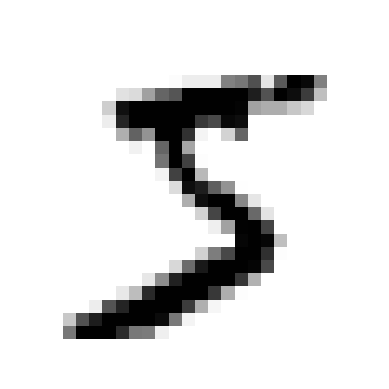

In [10]:
import matplotlib.pyplot as plt

# 28x28 모양의 2차원 어레리로 변환 후 이미지 그리기

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# 첫째 이미지 그리기
plot_digit(X[0])
plt.show()

In [11]:
y[0]

'5'

**[EDA 요약]**

- X : 샘플 수는 70,000개의 이미지이며, 이미지는 길이가 784(=28x28)인 1차원 어레이로 되어 있다.

- y : 레이블 또한 70,000개 이며, 0부터 9까지의 숫자이다.

- X[0] 첫째 손글씨 이미지는 5를 표현하는 것으로 보이며 레이블인 y[0] 또한 숫자 5로 일치한다.

### 4. 데이터 전처리

- 본래 훈련모델 적용을 위해 훈련 데이터셋을 splite 하는 과정을 거쳐야 한다.

- 하지만 본 자료는 이미 6:1 의 비율로 훈련셋과 데이터셋으로 분류되어 있으니 확인 절차만 밟는다.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

60000 60000
10000 10000


### 5. Muchin Learning

- k-최근접 이웃 알고리즘은 데이터를 분류 시 주변 이웃들의 다수결에 따라 분류하며 이미지 분류 문제에 높은 성능을 보인다.

- 미리 모델을 훈련시키는 과정이 없으며 테스트 데이터가 주어지면 학습 데이터셋에서 가장 가까운 k-이웃을 찾아 예측을 수행한다.

- 데이터셋의 크기나 구조가 바뀌더라도 적용 가능하며, 특히 작은 규모의 데이터셋에서 효과적이다.

- Mnist와 같이 비교적 간단한 패턴을 가진 데이터셋에서는 더욱 효과적으로 알려져있다.

- K-NN은 데이터의 분포나 형태에 대해 가정을 하지 않으며 비선형적이거나 복잡한 데이터셋에도 적용이 가능하다.

- 모델의 튜닝 과정이 비교적 간단하다.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [14]:
base_accuracy = knn_clf.score(X_test, y_test)

base_accuracy

0.9688

- 97%에 육박하는 정확도가 나온다. 성능을 보다 올리기 위해 그리드 탐색을 이용하여 최적의 하이퍼파라미터를 찾아 본다.

- 전체 훈련셋을 이용하면 그리드 탐색 훈련이 매우 오래 걸린다. 

- 따라서 먼저 10,000개의 훈련셋을 이용하여 모델의 판단 여부를 결정한 후, 

  그리드 탐색 훈련을 시도하고 이를 통해 최적의 하이퍼파라미터 조합을 찾는다.

- 본 과정에서는 10,000개의 데이터셋에 대한 효과를 검증하여 바로 60,000개의 데이터셋을 적용한다.

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:60000], y_train[:60000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [17]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [18]:
grid_search.best_score_

0.9716166666666666

- 테스트 셋에 대한 정확도를 확인하면 97% 정확도를 달성하였다.

In [19]:
grid_search.best_estimator_.fit(X_train, y_train)

tuned_accuracy = grid_search.score(X_test, y_test)

tuned_accuracy

0.9714